In [2]:
import pandas as pd
import numpy as np
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from catboost import CatBoostClassifier


In [76]:
# Load dataset
data = pd.read_csv("Merged.csv")

# Drop missing values
data = data.dropna()

# Fix label inconsistencies
label_corrections = {
    "Neutural": "Neutral", "Meutral": "Neutral", "N EUTRAL": "Neutral",
    "NEUTRANEG": "Neutral", "Negetive": "Negative", "NEGNEG": "Negative",
    "Negativee": "Negative", "NEG": "Negative"
}
data['tag'] = data['tag'].replace(label_corrections)

# Remove 'Neutral' labels
data = data[data['tag'] != 'Neutral']

# Balance the dataset
unique_labels = data['tag'].unique()
positive_class_label = unique_labels[0]
positive_class = data[data['tag'] == positive_class_label]

if len(positive_class) >= 8550:
    rows_to_remove = positive_class.sample(n=8550, random_state=42)
    data = data.drop(rows_to_remove.index)

print("✅ Dataset cleaned successfully!")


✅ Dataset cleaned successfully!


In [77]:
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-bn/master/stopwords-bn.txt"
response = requests.get(stopwords_url)

if response.status_code == 200:
    stop_words_bangla = set(response.text.splitlines())
    data['comment'] = data['comment'].apply(lambda x: ' '.join(
        [word for word in str(x).split() if word.lower() not in stop_words_bangla]
    ))

print("✅ Stopwords removed!")


✅ Stopwords removed!


In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    data['comment'], data['tag'], test_size=0.2, random_state=42
)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("✅ TF-IDF and label encoding completed!")


✅ TF-IDF and label encoding completed!


In [79]:
# Initialize CatBoost
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    verbose=10,
    random_seed=42
)

# Train
catboost_model.fit(X_train_tfidf.toarray(), y_train_encoded)

print("✅ CatBoost model trained!")


0:	learn: 0.6924239	total: 17.2ms	remaining: 1.7s
10:	learn: 0.6890288	total: 173ms	remaining: 1.4s
20:	learn: 0.6867112	total: 328ms	remaining: 1.24s
30:	learn: 0.6848849	total: 481ms	remaining: 1.07s
40:	learn: 0.6835036	total: 635ms	remaining: 914ms
50:	learn: 0.6820013	total: 788ms	remaining: 757ms
60:	learn: 0.6808006	total: 943ms	remaining: 603ms
70:	learn: 0.6797367	total: 1.1s	remaining: 448ms
80:	learn: 0.6787090	total: 1.25s	remaining: 294ms
90:	learn: 0.6777588	total: 1.41s	remaining: 139ms
99:	learn: 0.6769286	total: 1.55s	remaining: 0us
✅ CatBoost model trained!


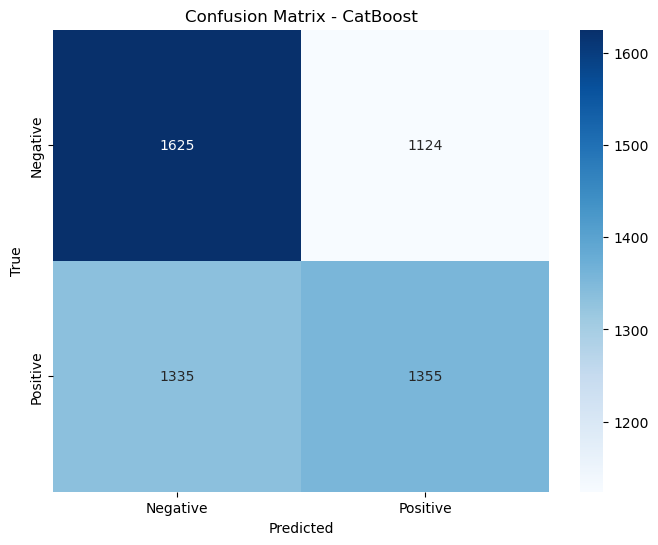

In [80]:
y_pred_probs = catboost_model.predict_proba(X_test_tfidf.toarray())
y_pred = np.argmax(y_pred_probs, axis=1)

conf_matrix = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CatBoost')
plt.show()


In [81]:
print("Classification Report:\n")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_, zero_division=0))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.55      0.59      0.57      2749
    Positive       0.55      0.50      0.52      2690

    accuracy                           0.55      5439
   macro avg       0.55      0.55      0.55      5439
weighted avg       0.55      0.55      0.55      5439



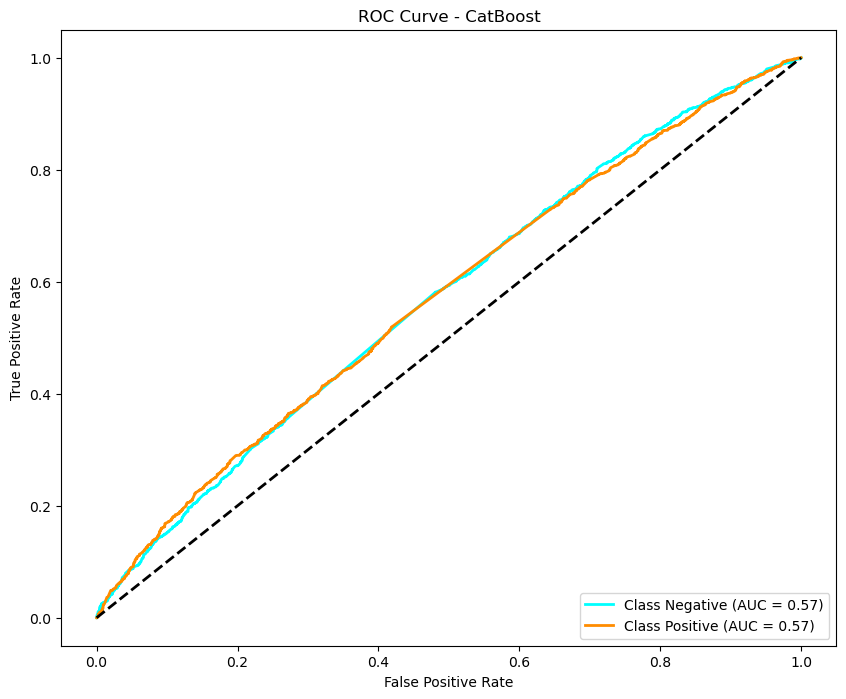

In [82]:
y_test_bin = np.eye(len(label_encoder.classes_))[y_test_encoded]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(label_encoder.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc="lower right")
plt.show()


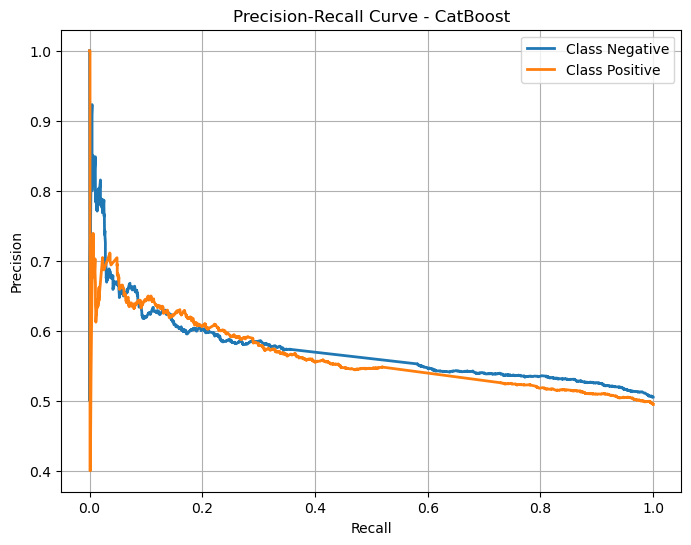

In [83]:
plt.figure(figsize=(8,6))

for i in range(len(label_encoder.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {label_encoder.classes_[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - CatBoost")
plt.legend(loc="best")
plt.grid()
plt.show()
